**Summary from exposure analysis:** 
- ARK has statistically significant betas to SPY, Treasuries and commodities
- ARK performs better worse in market downturns
- With the greatest statistical conviction,  we can say that the mean returns of ARK differs when SPY has cumulative returns of +/- 10% in a 50-day window 
- Large healthcare exposure

**Todo:**
- Calibrate option hedging strategy, buying 10% in the money puts with T=50 days expiry and sell 10% in the money calls with T=50 days expiry
- Investigate healthcare ETF's 
- Invetsigate tail risks that may have not materialized yet



In [266]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import numpy as np
from pandas.tseries.offsets import BDay




In [267]:
port_weights = pd.read_csv("./data/weights.csv", parse_dates=True)
etf_holdings = pd.read_csv("./data/holdings.csv", parse_dates=True)
macro_retz = pd.read_csv("./data/macro_retz.csv", parse_dates=True)
synth_retz = pd.read_csv("./data/synth_ark_rets.csv", parse_dates=True)
cum_retz = pd.read_csv("./data/cum_retz.csv", parse_dates=True)
ark = pd.read_csv("./data/ark.csv", parse_dates=True)

**Load in and visualize the up-swings and down-swings which we are trying to hedge against**

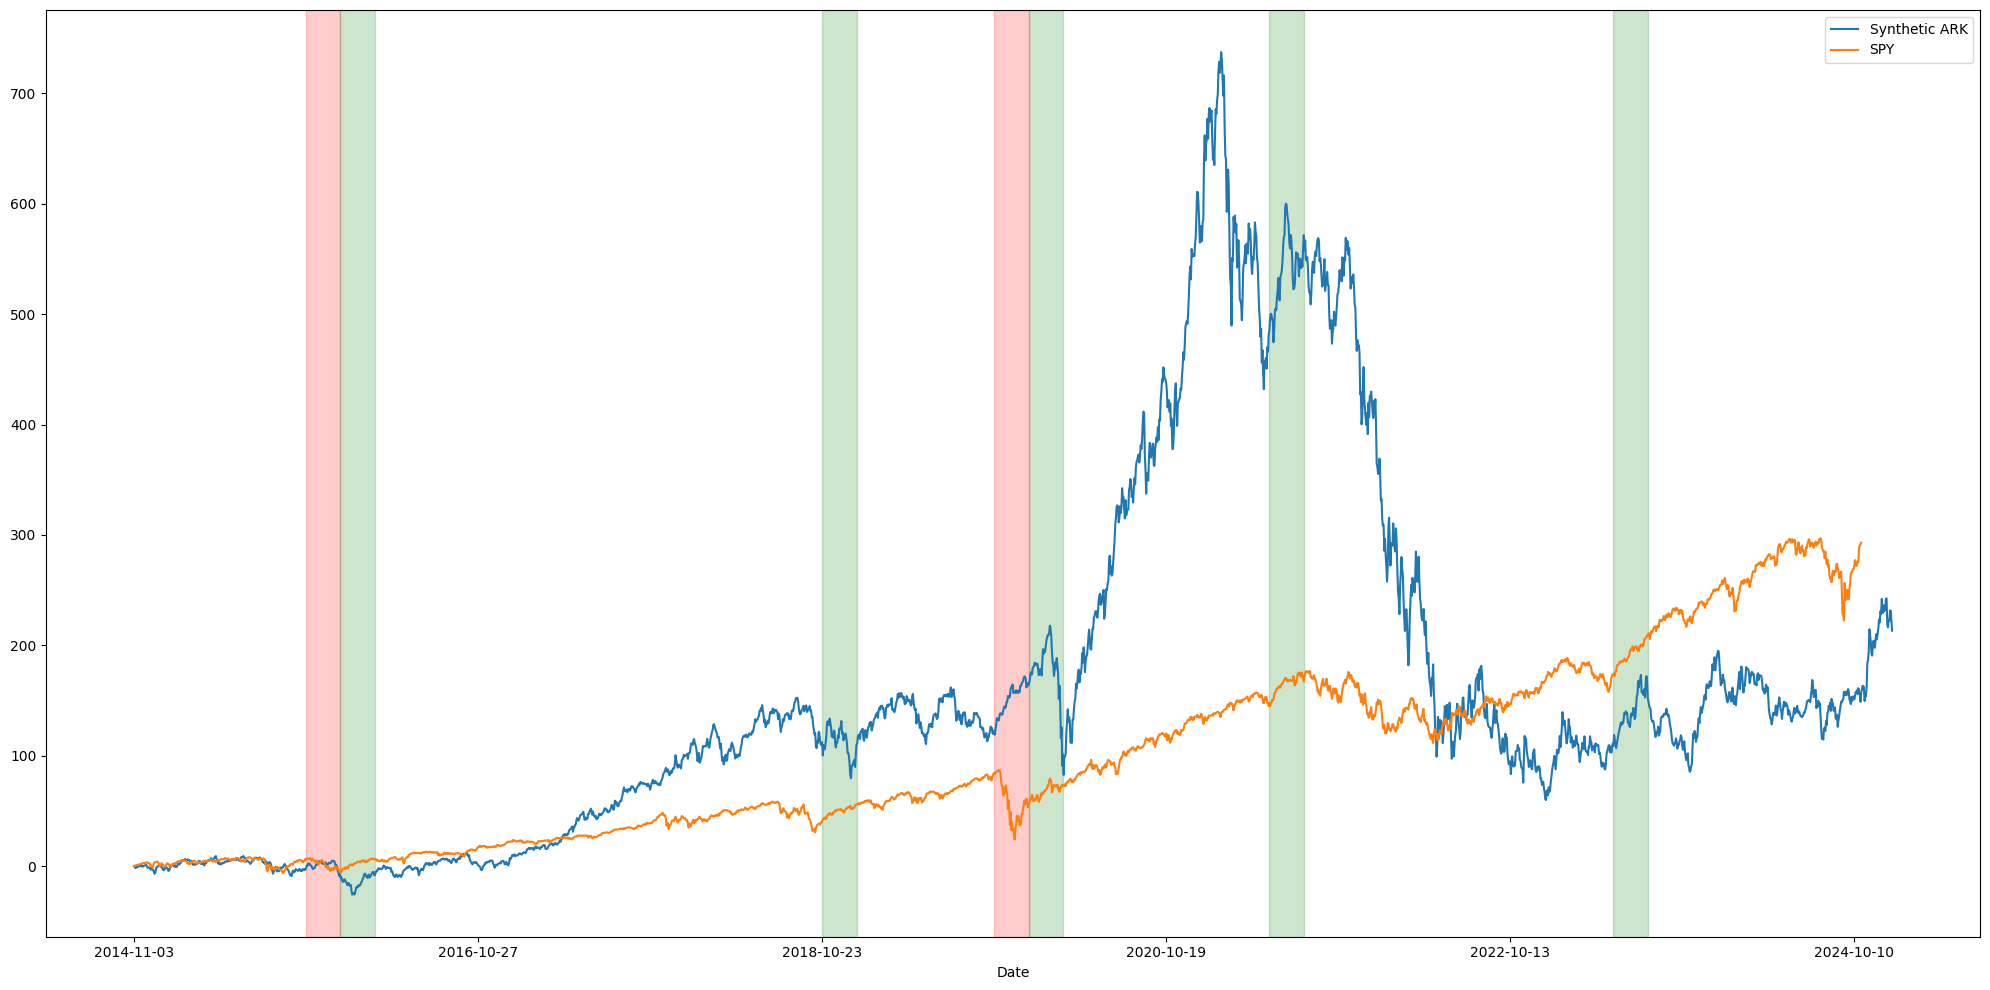

In [268]:
from helper_functions import label_market_swings 

macro_retz = label_market_swings(macro_retz, window = 50)

plot_df = pd.concat([ark, macro_retz['SPY'], macro_retz['upswing'], macro_retz['downswing']], axis = 1)
plot_df.set_index('Date', inplace = True)
plot_df.columns = ['ARK', 'SPY', 'upswing', 'downswing']
plot_df['ARK'] = ((1 + plot_df['ARK']).cumprod() - 1) * 100
plot_df['SPY'] = ((1 + plot_df['SPY']).cumprod() - 1) * 100

fig, ax = plt.subplots(figsize = (20, 10))
plot_df['ARK'].plot(ax = ax, label = 'Synthetic ARK')
plot_df['SPY'].plot(ax = ax, label = 'SPY')
ymin, ymax = ax.get_ylim()

in_upswing = False
for i in range(len(plot_df)):
    if plot_df['upswing'].iloc[i] == 1 and not in_upswing:
        ups_start = i
        in_upswing = True
    elif plot_df["upswing"].iloc[i] == 0 and in_upswing:
        ups_end = i
        ax.axvspan(ups_start, ups_end, color='green', alpha=0.2)
        in_upswing = False

in_downswing = False
for i in range(len(plot_df)):
    if plot_df["downswing"].iloc[i] == 1 and not in_downswing:
        down_start = i
        in_downswing = True
    elif plot_df["downswing"].iloc[i] == 0 and in_downswing:
        down_end = i
        ax.axvspan(down_start, down_end, color='red', alpha=0.2)
        in_downswing = False
plt.legend()
plt.tight_layout()



**LOAD AND CLEAN OPTION DATA**

In [269]:
option_data = pd.read_csv("./data/options.csv", parse_dates = True)
option_data['date'] = pd.to_datetime(option_data['date'])
option_data.set_index('date', inplace=True)
columns_to_keep = ['days', 'strike_price', 'cp_flag',  'premium',  'delta', 'gamma', 'vega', 'theta']
option_data = option_data[columns_to_keep]
spy_price = pd.read_csv("./data/spy_prices.csv", parse_dates=True)
spy_price['Date'] = pd.to_datetime(spy_price['Date'], utc=True)
spy_price['Date'] = spy_price['Date'].dt.normalize().dt.tz_localize(None)
spy_price.set_index('Date', inplace=True)
option_data.index = option_data.index.normalize()
option_data = option_data.join(spy_price)
option_data.rename(columns={'Close':'SPY'}, inplace=True)
option_data

,days,strike_price,cp_flag,premium,delta,gamma,vega,theta,SPY
2014-01-02,10,182.927456,C,1.419628,0.503879,0.112071,12.079142,-26.031128,NaN
2014-01-02,30,182.949524,C,2.545279,0.506954,0.062499,20.919505,-15.652547,NaN
2014-01-02,60,182.990267,C,3.723820,0.510174,0.042709,29.579539,-11.528563,NaN
2014-01-02,91,182.207795,C,5.071038,0.538627,0.033943,35.665870,-10.137282,NaN
2014-01-02,122,182.251810,C,5.849060,0.530419,0.028933,41.513468,-9.208565,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-31,182,459.728682,P,19.151897,-0.541761,0.011287,120.287593,-7.297156,439.970764
2023-08-31,273,464.974639,P,25.284541,-0.553933,0.009303,142.822738,-4.408136,439.970764
2023-08-31,365,470.293355,P,30.665202,-0.569648,0.008479,160.245994,-2.718230,439.970764
2023-08-31,547,479.823396,P,40.379025,-0.589740,0.007348,189.943388,-0.864316,439.970764


Given we are hedging against market downturns of 10% in the next 50 days, at each timestep, keep option with min ||DTE - 50||^2 and min ||moneyness - 10||^2 for put and call. The code below filters all options and suggets one put and one call which fit hedging criteria for every time step

In [270]:
option_data = option_data.copy()
option_data = option_data.dropna()

#Computes monyeness of every put all call option
def compute_moneyness(row):
    if row['cp_flag'] == 'C':
        return (row['SPY'] / row['strike_price']) - 1
    elif row['cp_flag'] == 'P':
        return (row['strike_price'] / row['SPY']) - 1
    else:
        return None

option_data.loc[:,'moneyness'] = option_data.apply(compute_moneyness, axis=1)

# Given target DTE and moneyness, compute the trade score
target_dte = 50 
target_moneyness = 0.10

option_data.loc[:,'dte_diff'] = (option_data.loc[:,'days'] - target_dte).abs()
option_data.loc[:,'moneyness_diff'] = (option_data.loc[:,'moneyness'] - target_moneyness).diff()
option_data.loc[:,'trade_score'] = option_data.loc[:,'dte_diff'] + 10 * option_data.loc[:,'moneyness_diff']

option_data_sorted = option_data.sort_values(['trade_score'])

option_data_sorted = option_data_sorted.copy()
option_data_sorted.loc[:,'datetime'] = option_data_sorted.index 

#Filter options to best put and call options for each date 
best_options = (
    option_data_sorted
    .groupby(['datetime', 'cp_flag'], sort=False)
    .first()
    .reset_index()
)

best_options.set_index('datetime', inplace=True)
best_options.sort_index(inplace=True)
best_options


,cp_flag,days,strike_price,premium,delta,gamma,vega,theta,SPY,moneyness,dte_diff,moneyness_diff,trade_score
datetime,,,,,,,,,,,,,
2014-10-31,P,60,200.593303,4.260579,-0.486980,0.036959,32.425094,-12.740187,167.990204,0.194077,10,-0.006511,9.934886
2014-10-31,C,60,200.593303,4.757017,0.550438,0.037766,31.815263,-14.186466,167.990204,-0.162533,10,0.004542,10.045420
2014-11-03,P,60,200.657940,4.434677,-0.486228,0.035463,32.435418,-13.404036,168.081848,0.193811,10,-0.006478,9.935217
2014-11-03,C,60,200.657940,4.782514,0.549122,0.037589,31.812122,-14.387708,168.081848,-0.162346,10,0.004521,10.045210
2014-11-04,C,60,200.004212,4.844026,0.547860,0.037021,31.838187,-14.840399,167.498688,-0.162524,10,0.004555,10.045548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29,P,60,451.428871,9.646016,-0.520862,0.019053,70.807894,-18.298881,438.808228,0.028761,10,0.004492,10.044920
2023-08-30,P,60,453.297548,9.332790,-0.523396,0.019891,70.925856,-17.312311,440.615570,0.028782,10,0.004495,10.044951
2023-08-30,C,60,453.297548,9.135186,0.508331,0.017285,72.667762,-39.250269,440.615570,-0.027977,10,-0.004266,9.957342


Need to compute hedge ratios, rolling regression against some macro-factors to get a time-series of rolling betas used for hedge calibration. 

In [271]:
macro_retz = macro_retz.drop(columns=['upswing', 'downswing'])
macro_retz.set_index('Date', inplace=True)
ark.set_index('Date', inplace=True)



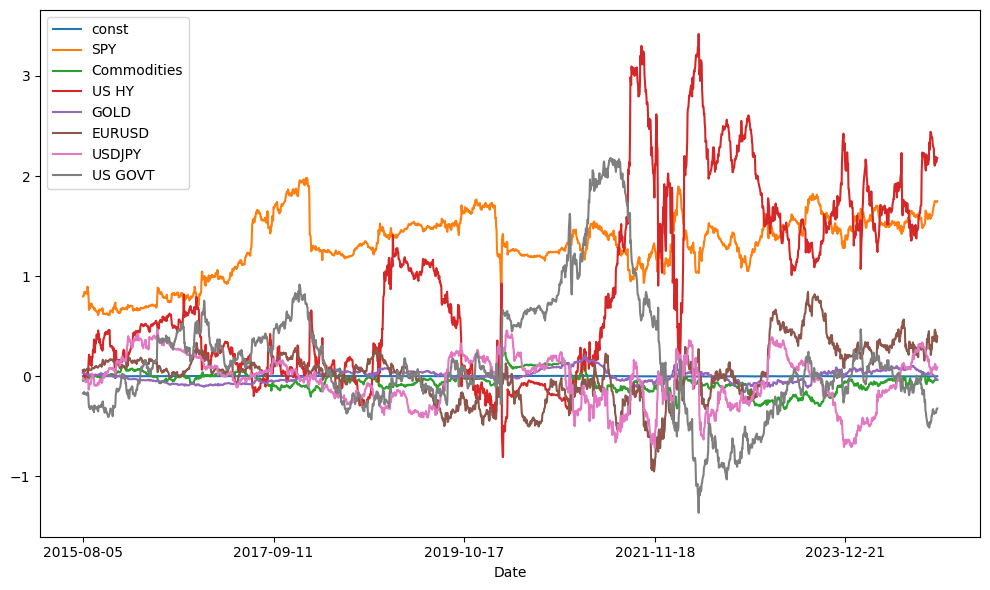

In [272]:
from helper_functions import rolling_reg
   
reg_df = ark.join(macro_retz, how = 'inner')
y = reg_df['Ark'].copy()
X = reg_df.drop(columns=['Ark'])
betas_df = rolling_reg(y, X, window=180, plot=True)

In [273]:
betas_df.index = pd.to_datetime(betas_df.index).normalize()

ark_prices = pd.read_csv("./data/ark_prices.csv", parse_dates=True)
ark_prices = ark_prices.dropna()
ark_prices = ark_prices.rename(columns={'Unnamed: 0':'Date'})
ark_prices['Date'] = pd.to_datetime(ark_prices['Date'], utc=True)
ark_prices['Date'] = ark_prices['Date'].dt.normalize().dt.tz_localize(None)
ark_prices.set_index('Date', inplace=True)
ark_prices['Close'] = pd.to_numeric(ark_prices['Close'])



Some formulas I used: 

\begin{align*}
&\text{Market Exposure} = P_{ARK} * \beta_{SPY}\\
&\text{Number of Options for Beta Hedge} = \frac{\text{Market Exposure}}{\Delta * SPY * 100} \quad \text{The *100 is because the underlying of each option is 100 SPY contracts}\\
&\text{Hedge Cost} = \text{Option Premium} * 100 \quad \quad (\text{+ for calls (going short) and - for puts (going long)})
\end{align*}

In [274]:

best_options.loc[:,'Ark Price'] = pd.to_numeric(ark_prices['Close'])

#Beta to market at any given time
best_options.loc[ :,'Beta'] = betas_df['SPY']

#Market Exporsue
best_options.loc[:,'Market Exposure'] = best_options.loc[:,'Beta'] * best_options.loc[:,'Ark Price']

#No. of options
best_options.loc[:,'Num Options'] = (best_options.loc[:,'Market Exposure'] /(best_options.loc[:,'delta']* best_options.loc[:,'SPY'] * 100)).abs()

#For easy comparison between ARK price and options, shift to tradeble ARK days
best_options.loc[:, 'days'] = pd.to_numeric(best_options.loc[:,'days'])
best_options.loc[:,'Expiry'] = best_options.index + best_options.loc[:,'days'].apply(lambda x: BDay(x))

#For easy payout computation, fetch SPY price at expiry
best_options.loc[:,'SPY At Expiry'] = best_options.loc[:,'Expiry'].map(spy_price['Close'])

best_options.loc[:,'Hedge Cost'] = best_options.loc[:,'Num Options'] * best_options.loc[:,'premium'] * 100  
best_options

/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_13919/2880621303.py:14: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  best_options.loc[:,'Expiry'] = best_options.index + best_options.loc[:,'days'].apply(lambda x: BDay(x))


,cp_flag,days,strike_price,premium,delta,gamma,vega,theta,SPY,moneyness,dte_diff,moneyness_diff,trade_score,Ark Price,Beta,Market Exposure,Num Options,Expiry,SPY At Expiry,Hedge Cost
datetime,,,,,,,,,,,,,,,,,,,,
2014-10-31,P,60,200.593303,4.260579,-0.486980,0.036959,32.425094,-12.740187,167.990204,0.194077,10,-0.006511,9.934886,18.391508,NaN,NaN,NaN,2015-01-23 00:00:00,171.689957,NaN
2014-10-31,C,60,200.593303,4.757017,0.550438,0.037766,31.815263,-14.186466,167.990204,-0.162533,10,0.004542,10.045420,18.391508,NaN,NaN,NaN,2015-01-23 00:00:00,171.689957,NaN
2014-11-03,P,60,200.657940,4.434677,-0.486228,0.035463,32.435418,-13.404036,168.081848,0.193811,10,-0.006478,9.935217,18.391508,NaN,NaN,NaN,2015-01-26 00:00:00,172.091965,NaN
2014-11-03,C,60,200.657940,4.782514,0.549122,0.037589,31.812122,-14.387708,168.081848,-0.162346,10,0.004521,10.045210,18.391508,NaN,NaN,NaN,2015-01-26 00:00:00,172.091965,NaN
2014-11-04,C,60,200.004212,4.844026,0.547860,0.037021,31.838187,-14.840399,167.498688,-0.162524,10,0.004555,10.045548,18.283218,NaN,NaN,NaN,2015-01-27 00:00:00,169.822021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29,P,60,451.428871,9.646016,-0.520862,0.019053,70.807894,-18.298881,438.808228,0.028761,10,0.004492,10.044920,42.951790,1.781789,76.531007,0.003348,2023-11-21 00:00:00,444.385437,3.229892
2023-08-30,P,60,453.297548,9.332790,-0.523396,0.019891,70.925856,-17.312311,440.615570,0.028782,10,0.004495,10.044951,43.249310,1.813487,78.432082,0.003401,2023-11-22 00:00:00,446.101135,3.174059
2023-08-30,C,60,453.297548,9.135186,0.508331,0.017285,72.667762,-39.250269,440.615570,-0.027977,10,-0.004266,9.957342,43.249310,1.813487,78.432082,0.003502,2023-11-22 00:00:00,446.101135,3.198930


In [275]:
call_best = best_options[best_options['cp_flag'] == 'C']    
put_best = best_options[best_options['cp_flag'] == 'P']

**WEEKLY REBALANCING OPTION HEDGE**

We are going long put and short call, so payoff for each looks like
\begin{align*}
&P(Call) = - (SPY - Strike)^+ * \text{Number of Contracts} \\
&P(Put) = (Strike - SPY)^+ * \text{Number of Contracts}
\end{align*}

In [276]:
weekly_call = call_best.resample('W').first()
weekly_puts = put_best.resample('W').first()

weekly_call.loc[:,'Option Payoff'] = -(weekly_call['SPY At Expiry'] - weekly_call['strike_price']).clip(lower=0) * 100 
weekly_call.loc[:,'Scaled Option Payoff'] = weekly_call['Option Payoff'] * weekly_call['Num Options']

weekly_puts.loc[:,'Option Payoff'] = (weekly_puts['strike_price'] - weekly_puts['SPY At Expiry']).clip(lower=0) * 100
weekly_puts.loc[:,'Scaled Option Payoff'] = weekly_puts['Option Payoff'] * weekly_puts['Num Options']






**COMBINING WEEKLY OPTIONS WITH ARK PRICES TO COMPUTE RETURNS**

In [277]:
hedge_retz = ark_prices.copy()

for col in ['Call Cost', 'Put Cost', 'Call Payoff', 'Put Payoff']:
    hedge_retz[col] = 0.0


# Given difference in trading calendar, this maps the option dates to closest ARK trading days
weekly_call.index = pd.to_datetime([
    hedge_retz.index.asof(d) if d >= hedge_retz.index[0] else pd.NaT
    for d in weekly_call.index
])

weekly_puts.index = pd.to_datetime([
    hedge_retz.index.asof(d) if d >= hedge_retz.index[0] else pd.NaT
    for d in weekly_puts.index
])

weekly_call['Expiry']  = pd.to_datetime([
    hedge_retz.index.asof(d) if d >= hedge_retz.index[0] else pd.NaT
    for d in weekly_call['Expiry']
])

weekly_puts['Expiry'] = pd.to_datetime([
    hedge_retz.index.asof(d) if d >= hedge_retz.index[0] else pd.NaT
    for d in weekly_puts['Expiry']
])


#Populates the hedge_retz dataframe with the costs and payoffs of the options
hedge_retz.loc[weekly_call.index, 'Call Cost'] += weekly_call['Hedge Cost']
hedge_retz.loc[weekly_call['Expiry'], 'Call Payoff'] += weekly_call['Scaled Option Payoff']

hedge_retz.loc[weekly_puts.index, 'Put Cost'] -= weekly_puts['Hedge Cost']
hedge_retz.loc[weekly_puts['Expiry'], 'Put Payoff'] += weekly_puts['Scaled Option Payoff']
hedge_retz.loc[:, 'Call Cost'] = hedge_retz['Call Cost'].fillna(0)
hedge_retz.loc[:, 'Put Cost'] = hedge_retz['Put Cost'].fillna(0)
hedge_retz.loc[:, 'Call Payoff'] = hedge_retz['Call Payoff'].fillna(0)
hedge_retz.loc[:, 'Put Payoff'] = hedge_retz['Put Payoff'].fillna(0)

hedge_retz.fillna(0, inplace=True)
hedge_retz


,Close,Call Cost,Put Cost,Call Payoff,Put Payoff
Date,,,,,
2014-10-31,18.391508,0.0,0.0,0.0,0.0
2014-11-03,18.391508,0.0,0.0,0.0,0.0
2014-11-04,18.283218,0.0,0.0,0.0,0.0
2014-11-05,18.048588,0.0,0.0,0.0,0.0
2014-11-06,18.174923,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-12-23,59.240002,0.0,0.0,0.0,0.0
2024-12-24,60.959999,0.0,0.0,0.0,0.0
2024-12-26,60.959999,0.0,0.0,0.0,0.0


In [278]:
hedge_retz['Ark Delta P']  = hedge_retz['Close'].diff()
hedge_retz = hedge_retz.dropna()
hedge_retz = hedge_retz.loc[:'2023-09-01']

To generate artifical portfolio prices, I used: 

\begin{align*}
\text{Portfolio Value}_{t+1} = \text{Portfolio Value}_{t} + (\text{Ark Price}_{t+1} - \text{Ark Price}_{t}) + \text{Cost of Entering New Hedge} + \text{Payoff from Existing Hedge}
\end{align*}

or more simply,

**DAILY PRICE CHANGE OF HEDGE PORTFOLIO IS DAILY PRICE CHANGE OF UNDERLYING ETF PLUS ANY CASHFLOWS FROM HEDGE** 

In [ ]:
hedge_retz['Cash'] = 0.0 
hedge_retz['Interest Cost'] = 0.0
hedge_retz['Portfolio Value'] = hedge_retz['Close'].iloc[0]
funding_rate = 0.02/252

for i in range(1, len(hedge_retz)): 
    prev_date = hedge_retz.index[i-1]
    current_date = hedge_retz.index[i]
    prev_cash = hedge_retz.loc[prev_date, 'Cash']
    etf_price = hedge_retz.loc[current_date, 'Close']

    funding_cost = prev_cash * funding_rate

    net_flow = hedge_retz.loc[current_date, 'Call Cost'] + hedge_retz.loc[current_date, 'Put Cost'] + hedge_retz.loc[current_date, 'Call Payoff'] + hedge_retz.loc[current_date, 'Put Payoff']

    new_cash = funding_cost + net_flow + prev_cash

    hedge_retz.loc[current_date, 'Cash'] = new_cash
    hedge_retz.loc[current_date, 'Interest Cost'] = funding_cost
    hedge_retz.loc[current_date,'Portfolio Value']= etf_price  + new_cash



In [280]:
hedge_retz['Portfolio Returns'] = hedge_retz['Portfolio Value'].pct_change().dropna()



In [281]:
from helper_functions import GeomSummary, SummarizeReturns

summary = SummarizeReturns(hedge_retz['Portfolio Returns'])
print(summary)



Annualized Mean       0.331862
Annualized Std Dev    0.248137
Sharpe Ratio          1.337415
Sortino Ratio         3.401223
Max Drawdown         -0.264219
5% Daily VaR         -0.013045
dtype: float64


In [282]:
from backtest import BacktestEngine

backtest_df = hedge_retz[['Portfolio Returns']].copy()
backtest_df = backtest_df.dropna()
backtest_df = backtest_df.rename(columns={'Portfolio Returns':'daily_return'})
backtest_df.index.name= 'date'
backtest_df.reset_index(inplace=True)

spy_price.rename(columns={'Close':'Adj Close'}, inplace=True)
spy_price.reset_index(inplace=True)
bt_engine = BacktestEngine(backtest_df, spy_price)
bt_engine.get_all_metrics()


{'Annualized Sharpe': np.float64(1.252943788502775),
 'Annualized Sortino': np.float64(3.1898617135179106),
 'Information Ratio': np.float64(0.7836414979334265),
 'Downside Beta': np.float64(0.3750344053982216),
 'Max Drawdown': np.float64(-0.26712615865206324),
 'Calmar Ratio': np.float64(1.2501904594313469),
 'Treynor Ratio': np.float64(0.8081017294160527),
 'Standard Beta': np.float64(0.38593631148974317),
 'Omega Ratio': np.float64(1.460491690483373),
 'Value at Risk (VaR)': np.float64(-0.013058242675506702),
 'Conditional Value at Risk (CVaR)': np.float64(-0.019776786184866866),
 'Max Drawdown Duration': np.int64(640),
 'Profit Factor': np.float64(1.460491690483373),
 'Annualized Return': np.float64(0.3533780148780108),
 'Annualized Volatility': np.float64(0.24891064292119644),
 'Recovery Factor': np.float64(50.32417660045556),
 'Fama-French Regression': None,
 'Volatility Regression': None}

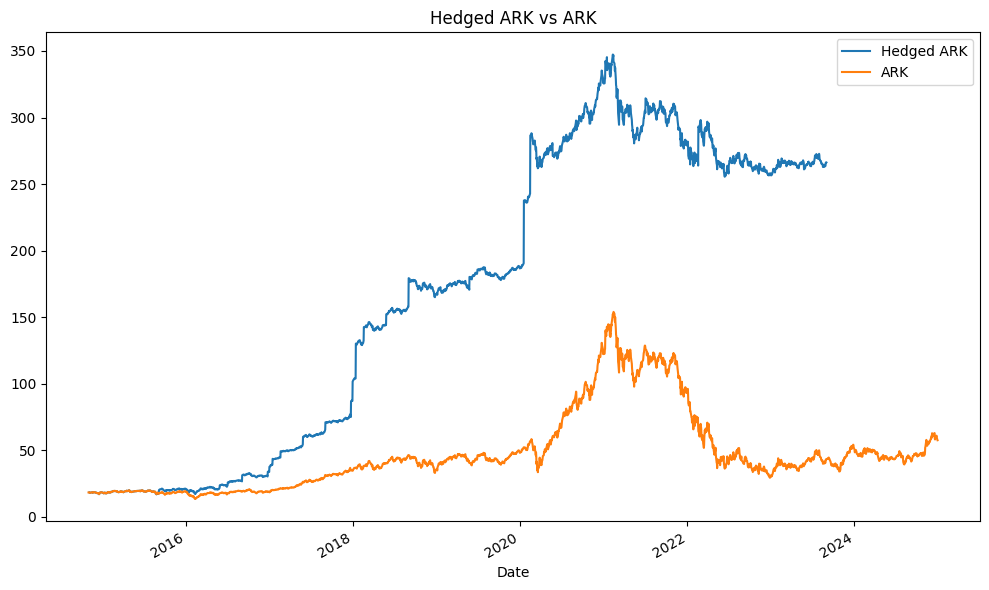

In [283]:
fig, ax = plt.subplots(figsize=(10, 6))
hedge_retz['Portfolio Value'].plot(ax=ax, label='Hedged ARK')
ark_prices['Close'].plot(ax=ax, label='ARK')
plt.title('Hedged ARK vs ARK')
plt.legend()
plt.tight_layout()

<Axes: xlabel='Date'>

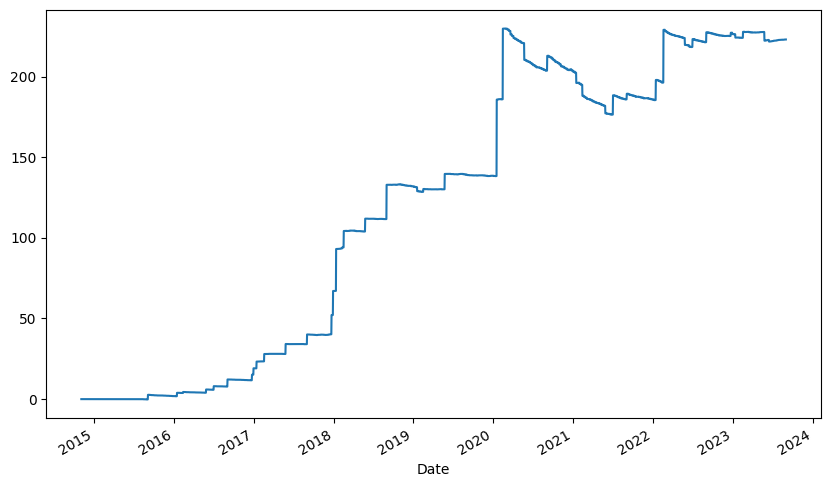

In [284]:
fig, ax = plt.subplots(figsize = (10,6))

hedge_retz['Cash'].plot(ax=ax, label= 'Cash Balance')

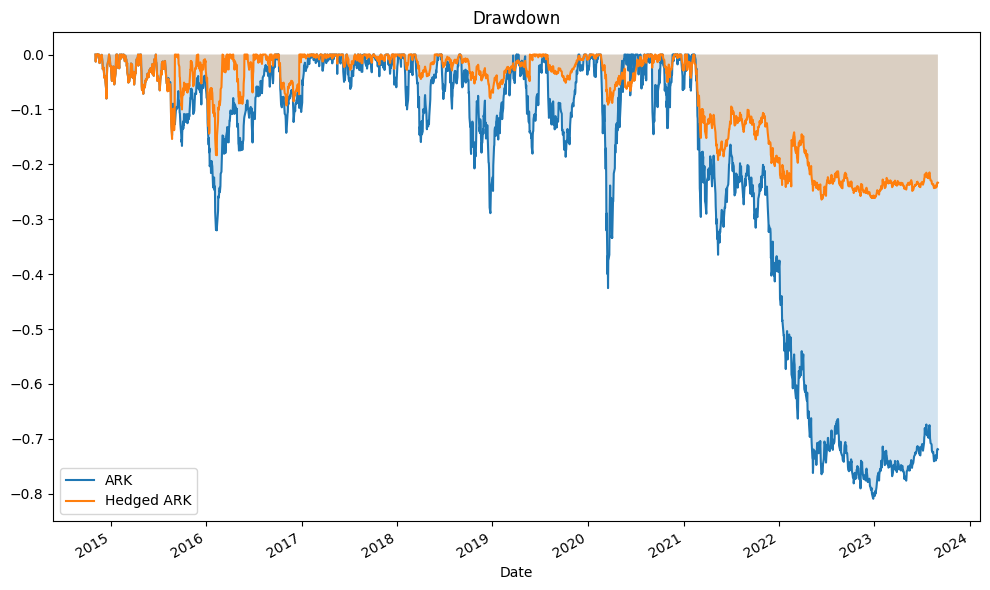

In [286]:
from helper_functions import plot_drawdown


ark.index = pd.to_datetime(ark.index, utc=True)
ark.index = ark.index.normalize().tz_localize(None)
ark = ark.loc[:'2023-09-01']
retz_df = pd.concat([ark['Ark'], hedge_retz['Portfolio Returns']], axis=1)

retz_df.columns = ['ARK', 'Hedged ARK']
retz_df = retz_df.dropna()
plot_drawdown(retz_df)